# Soil Moisture Plots

These are the plot types that people came up with on Dec. 8 that will be discussed on Dec. 17 or Dec. 18.

In [2]:
import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial

import math
import datetime
from datetime import date
import datetime
import time


import scipy
import os, os.path
import itertools
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys


# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/Stop_the_Rot/')
import onion_core as oc
import onion_plot_core as opc

In [3]:
data_dir = "/Users/hn/Documents/01_research_data/Stop_the_Rot/files_from_team/Columbia_Basin_Farm_A_red_onion_data/"
python_data_dir = "/Users/hn/Documents/01_research_data/Stop_the_Rot/Clean_For_Python/"

# Read Soil Moisture data

In [4]:
file_names = ["CLEANED (3) Real Time Soil Moisture data_Field A1.xlsx", 
              "CLEANED (3) Real Time Soil Moisture data_Field A2.xlsx", 
              "CLEANED (3) Real Time Soil Moisture data_Field A3.xlsx", 
              "CLEANED (3) Real Time Soil Moisture data_Field A4.xlsx",
              "CLEANED (3) Real Time Soil Moisture data_Field A5.xlsx"]

In [5]:
A1 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[0], head_count = 0)
A2 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[1], head_count = 0)
A3 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[2], head_count = 0)
A4 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[3], head_count = 0)
A5 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[4], head_count = 0)

A1["field"] = "A1"
A2["field"] = "A2"
A3["field"] = "A3"
A4["field"] = "A4"
A5["field"] = "A5"

In [6]:
A1.head(3)

,Date,Sensor1,Sensor2,Sensor3,Sensor4,field
0,2017-05-12 08:30:12.999997,0.71,0.43,0.34,0.49,A1
1,2017-05-12 09:00:16.000001,0.71,0.43,0.34,0.49,A1
2,2017-05-12 09:30:13.000000,0.71,0.43,0.34,0.49,A1


In [7]:
plot_dir = "/Users/hn/Documents/01_research_data/Stop_the_Rot/Plots/Dec17Meeting/"

# Sum of all sensors 

In [8]:
def add_senrosrs_sum(a_df):
    a_df['sensors_sum'] = a_df['Sensor1'] + a_df['Sensor2'] + a_df['Sensor3'] + a_df['Sensor4']
    
def add_depths_contribution_columns(a_df):
    a_df['Sensor1_contribution'] = 100 * (a_df['Sensor1'] / a_df['sensors_sum'])
    a_df['Sensor2_contribution'] = 100 * (a_df['Sensor2'] / a_df['sensors_sum'])
    a_df['Sensor3_contribution'] = 100 * (a_df['Sensor3'] / a_df['sensors_sum'])
    a_df['Sensor4_contribution'] = 100 * (a_df['Sensor4'] / a_df['sensors_sum'])

In [9]:
add_senrosrs_sum(A1)
add_senrosrs_sum(A2)
add_senrosrs_sum(A3)
add_senrosrs_sum(A4)
add_senrosrs_sum(A5)

add_depths_contribution_columns(A1)
add_depths_contribution_columns(A2)
add_depths_contribution_columns(A3)
add_depths_contribution_columns(A4)
add_depths_contribution_columns(A5)

# Smooth the sensors sum by moving window average

In [10]:
# mylist = [1, 2, 3, 4, 5, 6, 7]
# N = 3
# cumsum, moving_aves = [0], []

# for i, x in enumerate(mylist, 1):
#     cumsum.append(cumsum[i-1] + x)
#     if i>=N:
#         print (i)
#         print (cumsum[i])
#         print (cumsum[i-N])
#         print ("________________")
#         moving_ave = (cumsum[i] - cumsum[i-N])/N
#         #can do stuff with moving_ave here
#         moving_aves.append(moving_ave)
        
# moving_aves
# cumsum

In [17]:
def smooth_sensors_sum_window5(aDT, column_to_smooth = "sensors_sum", window_size=7):
    new_col_name = column_to_smooth + "_smoothed"
    mylist = list(aDT[column_to_smooth].values)
    cumsum, moving_aves = [0], []

    for ii, x in enumerate(mylist, 1):
        cumsum.append(cumsum[ii - 1] + x)
        if ii >= window_size:
            moving_ave = (cumsum[ii] - cumsum[ii - window_size])/window_size
            # can do stuff with moving_ave here
            moving_aves.append(moving_ave)

    aDT[new_col_name] = aDT[column_to_smooth].values
    start = int(window_size / 2)
    end = len(aDT.index) - int(window_size / 2) - 1
    aDT.loc[start: end, new_col_name] = moving_aves
    return(aDT)


In [18]:
win_size = 25
A1 = smooth_sensors_sum_window5(A1, column_to_smooth = "sensors_sum", window_size = win_size)
A2 = smooth_sensors_sum_window5(A2, column_to_smooth = "sensors_sum", window_size = win_size)
A3 = smooth_sensors_sum_window5(A3, column_to_smooth = "sensors_sum", window_size = win_size)
A4 = smooth_sensors_sum_window5(A4, column_to_smooth = "sensors_sum", window_size = win_size)
A5 = smooth_sensors_sum_window5(A5, column_to_smooth = "sensors_sum", window_size = win_size)

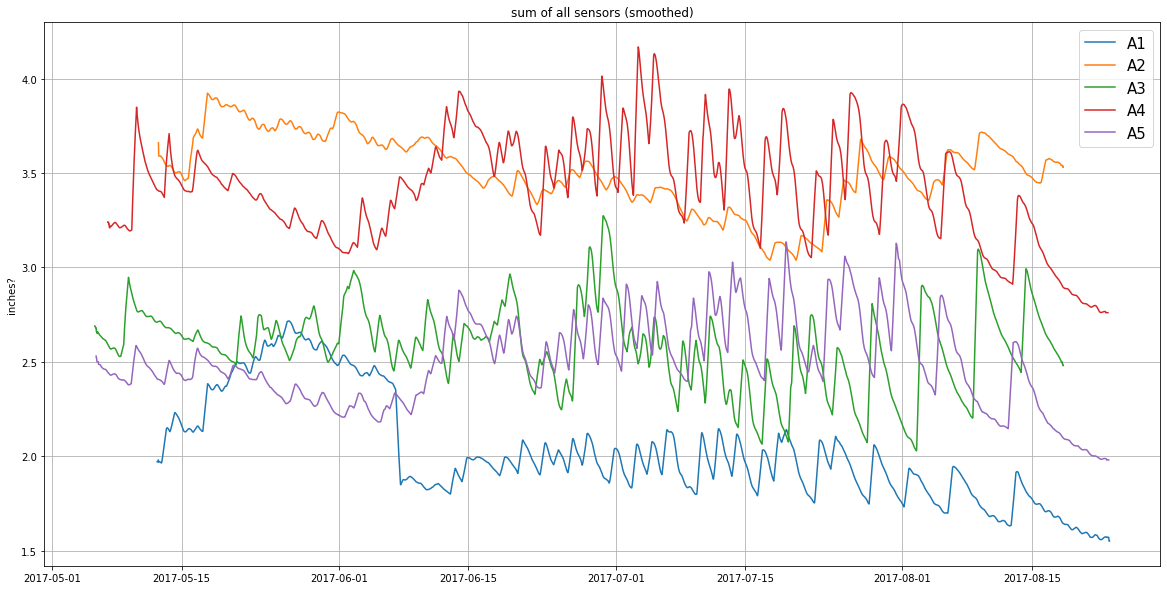

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.sensors_sum_smoothed.values, label="A1")
ax1.plot(A2.Date.values, A2.sensors_sum_smoothed.values, label="A2")
ax1.plot(A3.Date.values, A3.sensors_sum_smoothed.values, label="A3")
ax1.plot(A4.Date.values, A4.sensors_sum_smoothed.values, label="A4")
ax1.plot(A5.Date.values, A5.sensors_sum_smoothed.values, label="A5")
ax1.legend(loc="best", fontsize=15);
ax1.set(ylabel="inches?")
ax1.set_title("sum of all sensors (smoothed)");

file_name = plot_dir + "05_sum_of_sensors_smoothed_winSize_" + str(win_size) + ".png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [195]:
A1 = smooth_sensors_sum_window5(A1, column_to_smooth = "Sensor1_contribution", window_size = win_size)
A2 = smooth_sensors_sum_window5(A2, column_to_smooth = "Sensor1_contribution", window_size = win_size)
A3 = smooth_sensors_sum_window5(A3, column_to_smooth = "Sensor1_contribution", window_size = win_size)
A4 = smooth_sensors_sum_window5(A4, column_to_smooth = "Sensor1_contribution", window_size = win_size)
A5 = smooth_sensors_sum_window5(A5, column_to_smooth = "Sensor1_contribution", window_size = win_size)

A1 = smooth_sensors_sum_window5(A1, column_to_smooth = "Sensor2_contribution", window_size = win_size)
A2 = smooth_sensors_sum_window5(A2, column_to_smooth = "Sensor2_contribution", window_size = win_size)
A3 = smooth_sensors_sum_window5(A3, column_to_smooth = "Sensor2_contribution", window_size = win_size)
A4 = smooth_sensors_sum_window5(A4, column_to_smooth = "Sensor2_contribution", window_size = win_size)
A5 = smooth_sensors_sum_window5(A5, column_to_smooth = "Sensor2_contribution", window_size = win_size)

A1 = smooth_sensors_sum_window5(A1, column_to_smooth = "Sensor3_contribution", window_size = win_size)
A2 = smooth_sensors_sum_window5(A2, column_to_smooth = "Sensor3_contribution", window_size = win_size)
A3 = smooth_sensors_sum_window5(A3, column_to_smooth = "Sensor3_contribution", window_size = win_size)
A4 = smooth_sensors_sum_window5(A4, column_to_smooth = "Sensor3_contribution", window_size = win_size)
A5 = smooth_sensors_sum_window5(A5, column_to_smooth = "Sensor3_contribution", window_size = win_size)

A1 = smooth_sensors_sum_window5(A1, column_to_smooth = "Sensor4_contribution", window_size = win_size)
A2 = smooth_sensors_sum_window5(A2, column_to_smooth = "Sensor4_contribution", window_size = win_size)
A3 = smooth_sensors_sum_window5(A3, column_to_smooth = "Sensor4_contribution", window_size = win_size)
A4 = smooth_sensors_sum_window5(A4, column_to_smooth = "Sensor4_contribution", window_size = win_size)
A5 = smooth_sensors_sum_window5(A5, column_to_smooth = "Sensor4_contribution", window_size = win_size)

In [199]:
A5.head(2)

,Date,Sensor1,Sensor2,Sensor3,Sensor4,field,sensors_sum,Sensor1_contribution,Sensor2_contribution,Sensor3_contribution,Sensor4_contribution,sensors_sum_smoothed,Sensor1_contribution_smoothed,Sensor2_contribution_smoothed,Sensor3_contribution_smoothed,Sensor4_contribution_smoothed
0,2017-05-05 17:56:41,0.57,0.77,0.64,0.55,A5,2.53,22.529644,30.434783,25.296443,21.739130,2.53,22.529644,30.434783,25.296443,21.739130
1,2017-05-05 18:30:14,0.57,0.77,0.63,0.55,A5,2.52,22.619048,30.555556,25.000000,21.825397,2.52,22.619048,30.555556,25.000000,21.825397


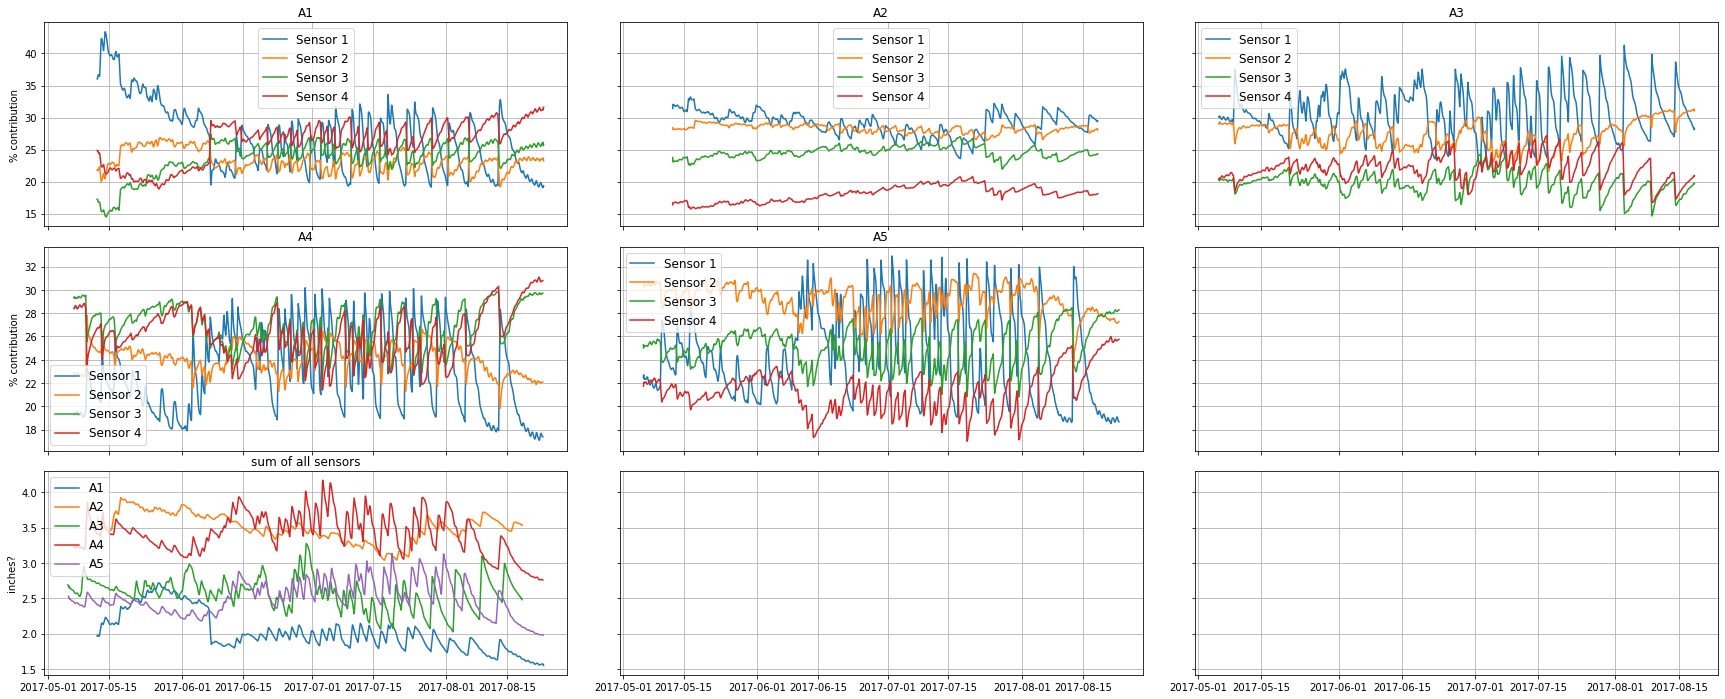

In [200]:
fig, axs = plt.subplots(3, 3, figsize=(30,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); 
ax4.grid(True); ax5.grid(True); ax6.grid(True);
ax7.grid(True); ax8.grid(True); ax9.grid(True);

ax1.plot(A1.Date.values, A1.Sensor1_contribution_smoothed.values, label="Sensor 1")
ax1.plot(A1.Date.values, A1.Sensor2_contribution_smoothed.values, label="Sensor 2")
ax1.plot(A1.Date.values, A1.Sensor3_contribution_smoothed.values, label="Sensor 3")
ax1.plot(A1.Date.values, A1.Sensor4_contribution_smoothed.values, label="Sensor 4")
ax1.legend(loc="best", fontsize=12);
ax1.set_title("A1");
ax1.set(ylabel="% contribution")
#  ax1.ylim = (0, 1.2)
# ax1.set_ylim([0.2, 1.3])

ax2.plot(A2.Date.values, A2.Sensor1_contribution_smoothed.values, label="Sensor 1")
ax2.plot(A2.Date.values, A2.Sensor2_contribution_smoothed.values, label="Sensor 2")
ax2.plot(A2.Date.values, A2.Sensor3_contribution_smoothed.values, label="Sensor 3")
ax2.plot(A2.Date.values, A2.Sensor4_contribution_smoothed.values, label="Sensor 4")
ax2.legend(loc="best", fontsize=12);
ax2.set_title("A2");
# ax2.set_ylim([0.2, 1.3])

ax3.plot(A3.Date.values, A3.Sensor1_contribution_smoothed.values, label="Sensor 1")
ax3.plot(A3.Date.values, A3.Sensor2_contribution_smoothed.values, label="Sensor 2")
ax3.plot(A3.Date.values, A3.Sensor3_contribution_smoothed.values, label="Sensor 3")
ax3.plot(A3.Date.values, A3.Sensor4_contribution_smoothed.values, label="Sensor 4")
ax3.legend(loc="best", fontsize=12);
ax3.set_title("A3");

# ax3.set_ylim([0.2, 1.3])

ax4.plot(A4.Date.values, A4.Sensor1_contribution_smoothed.values, label="Sensor 1")
ax4.plot(A4.Date.values, A4.Sensor2_contribution_smoothed.values, label="Sensor 2")
ax4.plot(A4.Date.values, A4.Sensor3_contribution_smoothed.values, label="Sensor 3")
ax4.plot(A4.Date.values, A4.Sensor4_contribution_smoothed.values, label="Sensor 4")
ax4.legend(loc="best", fontsize=12);
ax4.set(ylabel="% contribution")
ax4.set_title("A4");
# ax4.set_ylim([0.2, 1.3])

ax5.plot(A5.Date.values, A5.Sensor1_contribution_smoothed.values, label = "Sensor 1")
ax5.plot(A5.Date.values, A5.Sensor2_contribution_smoothed.values, label = "Sensor 2")
ax5.plot(A5.Date.values, A5.Sensor3_contribution_smoothed.values, label = "Sensor 3")
ax5.plot(A5.Date.values, A5.Sensor4_contribution_smoothed.values, label = "Sensor 4")
ax5.legend(loc="best", fontsize=12);
ax5.set_title("A5");
# ax5.set_ylim([0.2, 1.3])


ax7.plot(A1.Date.values, A1.sensors_sum_smoothed.values, label="A1")
ax7.plot(A2.Date.values, A2.sensors_sum_smoothed.values, label="A2")
ax7.plot(A3.Date.values, A3.sensors_sum_smoothed.values, label="A3")
ax7.plot(A4.Date.values, A4.sensors_sum_smoothed.values, label="A4")
ax7.plot(A5.Date.values, A5.sensors_sum_smoothed.values, label="A5")
ax7.legend(loc="best", fontsize=12);
ax7.set(ylabel="inches?")
ax7.set_title("sum of all sensors");
# ax6.ylim = (0, 4.2)
# ax6.set_ylim([1.3, 4.3])

file_name = plot_dir + "06_sum_and_contributions_smoothed_winsize_" + str(win_size) + ".png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

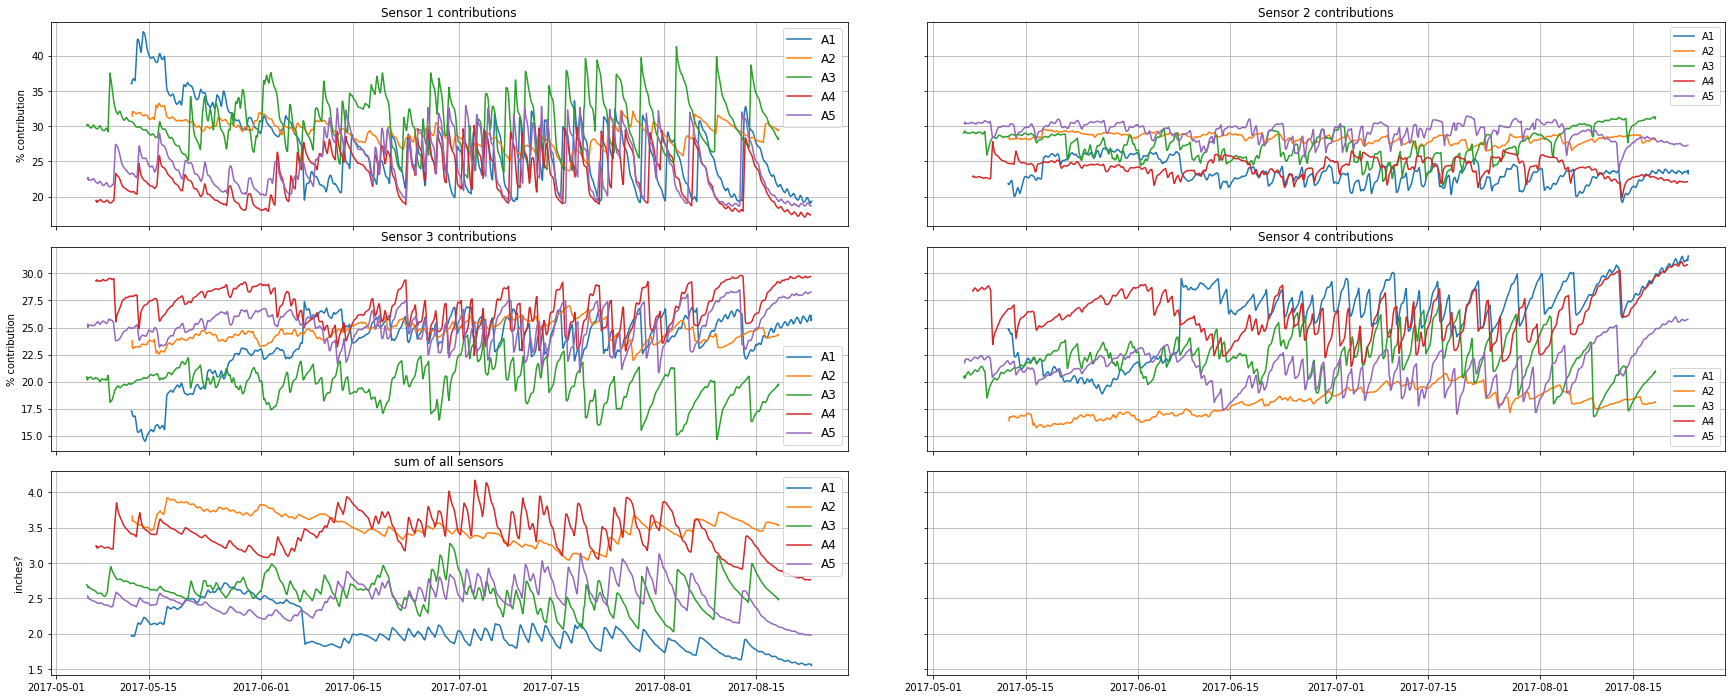

In [201]:
fig, axs = plt.subplots(3, 2, figsize=(30,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); 
ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.Sensor1_contribution_smoothed.values, label="A1")
ax1.plot(A2.Date.values, A2.Sensor1_contribution_smoothed.values, label="A2")
ax1.plot(A3.Date.values, A3.Sensor1_contribution_smoothed.values, label="A3")
ax1.plot(A4.Date.values, A4.Sensor1_contribution_smoothed.values, label="A4")
ax1.plot(A5.Date.values, A5.Sensor1_contribution_smoothed.values, label="A5")
ax1.legend(loc="best", fontsize=12);
ax1.set(ylabel="% contribution")
ax1.set_title("Sensor 1 contributions");
#  ax1.ylim = (0, 1.2)
# ax1.set_ylim([0.2, 1.3])

ax2.plot(A1.Date.values, A1.Sensor2_contribution_smoothed.values, label="A1")
ax2.plot(A2.Date.values, A2.Sensor2_contribution_smoothed.values, label="A2")
ax2.plot(A3.Date.values, A3.Sensor2_contribution_smoothed.values, label="A3")
ax2.plot(A4.Date.values, A4.Sensor2_contribution_smoothed.values, label="A4")
ax2.plot(A5.Date.values, A5.Sensor2_contribution_smoothed.values, label="A5")
ax2.legend(loc="best");
ax2.set_title("Sensor 2 contributions");
# ax2.set_ylim([0.2, 1.3])

ax3.plot(A1.Date.values, A1.Sensor3_contribution_smoothed.values, label="A1")
ax3.plot(A2.Date.values, A2.Sensor3_contribution_smoothed.values, label="A2")
ax3.plot(A3.Date.values, A3.Sensor3_contribution_smoothed.values, label="A3")
ax3.plot(A4.Date.values, A4.Sensor3_contribution_smoothed.values, label="A4")
ax3.plot(A5.Date.values, A5.Sensor3_contribution_smoothed.values, label="A5")
ax3.legend(loc="best", fontsize=12);
ax3.set(ylabel="% contribution")
ax3.set_title("Sensor 3 contributions");
# ax3.set_ylim([0.2, 1.3])

ax4.plot(A1.Date.values, A1.Sensor4_contribution_smoothed.values, label="A1")
ax4.plot(A2.Date.values, A2.Sensor4_contribution_smoothed.values, label="A2")
ax4.plot(A3.Date.values, A3.Sensor4_contribution_smoothed.values, label="A3")
ax4.plot(A4.Date.values, A4.Sensor4_contribution_smoothed.values, label="A4")
ax4.plot(A5.Date.values, A5.Sensor4_contribution_smoothed.values, label="A5")
ax4.legend(loc="best");
ax4.set_title("Sensor 4 contributions");
# ax4.set_ylim([0.2, 1.3])


ax5.plot(A1.Date.values, A1.sensors_sum_smoothed.values, label="A1")
ax5.plot(A2.Date.values, A2.sensors_sum_smoothed.values, label="A2")
ax5.plot(A3.Date.values, A3.sensors_sum_smoothed.values, label="A3")
ax5.plot(A4.Date.values, A4.sensors_sum_smoothed.values, label="A4")
ax5.plot(A5.Date.values, A5.sensors_sum_smoothed.values, label="A5")
ax5.legend(loc="best", fontsize=12);
ax5.set(ylabel="inches?")
ax5.set_title("sum of all sensors");
# ax6.ylim = (0, 4.2)
# ax6.set_ylim([1.3, 4.3])

file_name = plot_dir + "07_sum_and_contributions_smoothed_winsize" + str(win_size) + ".png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

# Smooth by Convolution

In [208]:
from collections import deque
from itertools import islice

def sliding_avg(iterable, N):        
    it = iter(iterable)
    window = deque(islice(it, N))        
    num_vals = len(window)

    if num_vals < N:
        msg = 'window size {} exceeds total number of values {}'
        raise ValueError(msg.format(N, num_vals))

    N = float(N) # force floating point division if using Python 2
    s = sum(window)
    
    while True:
        yield s/N
        try:
            nxt = next(it)
        except StopIteration:
            break
        s = s - window.popleft() + nxt
        window.append(nxt)


In [239]:
A1 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[0], head_count=1)
A2 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[1], head_count=1)
A3 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[2], head_count=1)
A4 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[3], head_count=1)
A5 = oc.read_xlsx_with_only_1sheet(path_n_fileName = data_dir + file_names[4], head_count=1)

A1["field"] = "A1"
A2["field"] = "A2"
A3["field"] = "A3"
A4["field"] = "A4"
A5["field"] = "A5"

In [240]:
add_senrosrs_sum(A1)
add_senrosrs_sum(A2)
add_senrosrs_sum(A3)
add_senrosrs_sum(A4)
add_senrosrs_sum(A5)

add_depths_contribution_columns(A1)
add_depths_contribution_columns(A2)
add_depths_contribution_columns(A3)
add_depths_contribution_columns(A4)
add_depths_contribution_columns(A5)

In [241]:
A1.head(2)

,Date,Sensor1,Sensor2,Sensor3,Sensor4,field,sensors_sum,Sensor1_contribution,Sensor2_contribution,Sensor3_contribution,Sensor4_contribution
0,2017-05-12 08:30:13,0.71,0.43,0.34,0.49,A1,1.97,36.040609,21.827411,17.258883,24.873096
1,2017-05-12 09:00:16,0.71,0.43,0.34,0.49,A1,1.97,36.040609,21.827411,17.258883,24.873096


In [242]:
def smooth_sensors_conv(aDT, column_to_smooth = "sensors_sum", window_size=7):
    new_col_name = column_to_smooth + "_smoothed"
    aDT[new_col_name] = aDT[column_to_smooth].values
    start = int(window_size / 2)
    end = len(aDT.index) - int(window_size / 2) - 1
    aDT.loc[start: end, new_col_name] = np.convolve(aDT[column_to_smooth], 
                                                    np.ones(window_size)/window_size, 
                                                    mode='valid')
    return(aDT)


In [245]:
win_size = 25
A1 = smooth_sensors_conv(A1, column_to_smooth = "sensors_sum", window_size = win_size)
A2 = smooth_sensors_conv(A2, column_to_smooth = "sensors_sum", window_size = win_size)
A3 = smooth_sensors_conv(A3, column_to_smooth = "sensors_sum", window_size = win_size)
A4 = smooth_sensors_conv(A4, column_to_smooth = "sensors_sum", window_size = win_size)
A5 = smooth_sensors_conv(A5, column_to_smooth = "sensors_sum", window_size = win_size)

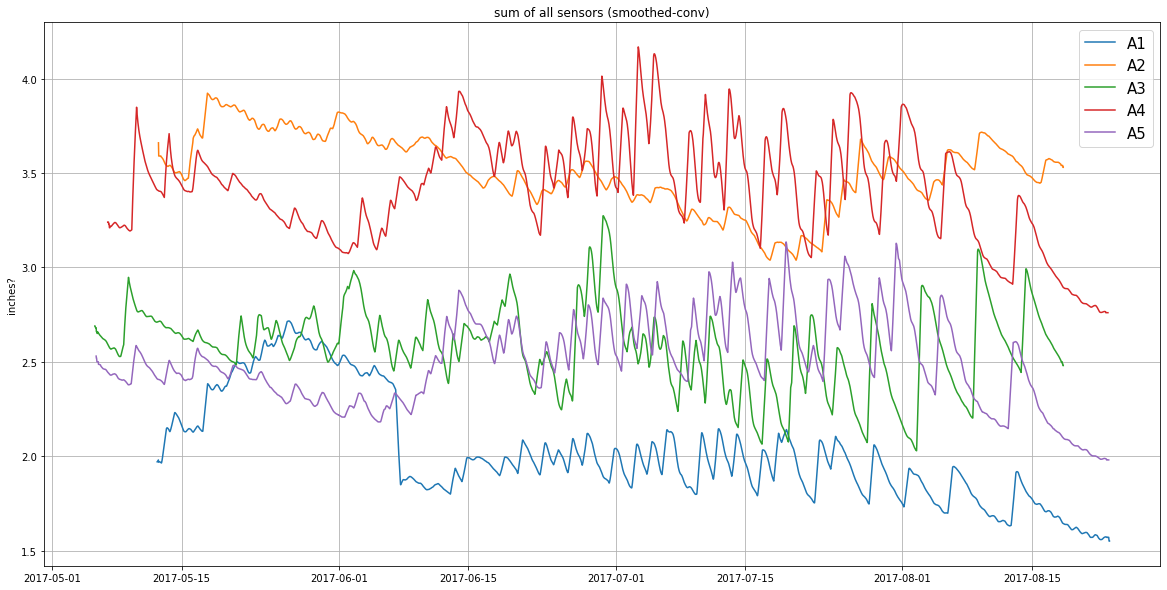

In [246]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,10),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

# (ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); # ax2.grid(True); ax3.grid(True); ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.sensors_sum_smoothed.values, label="A1")
ax1.plot(A2.Date.values, A2.sensors_sum_smoothed.values, label="A2")
ax1.plot(A3.Date.values, A3.sensors_sum_smoothed.values, label="A3")
ax1.plot(A4.Date.values, A4.sensors_sum_smoothed.values, label="A4")
ax1.plot(A5.Date.values, A5.sensors_sum_smoothed.values, label="A5")
ax1.legend(loc="best", fontsize=15);
ax1.set(ylabel="inches?")
ax1.set_title("sum of all sensors (smoothed-conv)");

file_name = plot_dir + "05_sum_of_sensors_conv_winSize_" + str(win_size) + ".png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [251]:
A1 = smooth_sensors_conv(A1, column_to_smooth = "Sensor1_contribution", window_size = win_size)
A2 = smooth_sensors_conv(A2, column_to_smooth = "Sensor1_contribution", window_size = win_size)
A3 = smooth_sensors_conv(A3, column_to_smooth = "Sensor1_contribution", window_size = win_size)
A4 = smooth_sensors_conv(A4, column_to_smooth = "Sensor1_contribution", window_size = win_size)
A5 = smooth_sensors_conv(A5, column_to_smooth = "Sensor1_contribution", window_size = win_size)

A1 = smooth_sensors_conv(A1, column_to_smooth = "Sensor2_contribution", window_size = win_size)
A2 = smooth_sensors_conv(A2, column_to_smooth = "Sensor2_contribution", window_size = win_size)
A3 = smooth_sensors_conv(A3, column_to_smooth = "Sensor2_contribution", window_size = win_size)
A4 = smooth_sensors_conv(A4, column_to_smooth = "Sensor2_contribution", window_size = win_size)
A5 = smooth_sensors_conv(A5, column_to_smooth = "Sensor2_contribution", window_size = win_size)

A1 = smooth_sensors_conv(A1, column_to_smooth = "Sensor3_contribution", window_size = win_size)
A2 = smooth_sensors_conv(A2, column_to_smooth = "Sensor3_contribution", window_size = win_size)
A3 = smooth_sensors_conv(A3, column_to_smooth = "Sensor3_contribution", window_size = win_size)
A4 = smooth_sensors_conv(A4, column_to_smooth = "Sensor3_contribution", window_size = win_size)
A5 = smooth_sensors_conv(A5, column_to_smooth = "Sensor3_contribution", window_size = win_size)

A1 = smooth_sensors_conv(A1, column_to_smooth = "Sensor4_contribution", window_size = win_size)
A2 = smooth_sensors_conv(A2, column_to_smooth = "Sensor4_contribution", window_size = win_size)
A3 = smooth_sensors_conv(A3, column_to_smooth = "Sensor4_contribution", window_size = win_size)
A4 = smooth_sensors_conv(A4, column_to_smooth = "Sensor4_contribution", window_size = win_size)
A5 = smooth_sensors_conv(A5, column_to_smooth = "Sensor4_contribution", window_size = win_size)

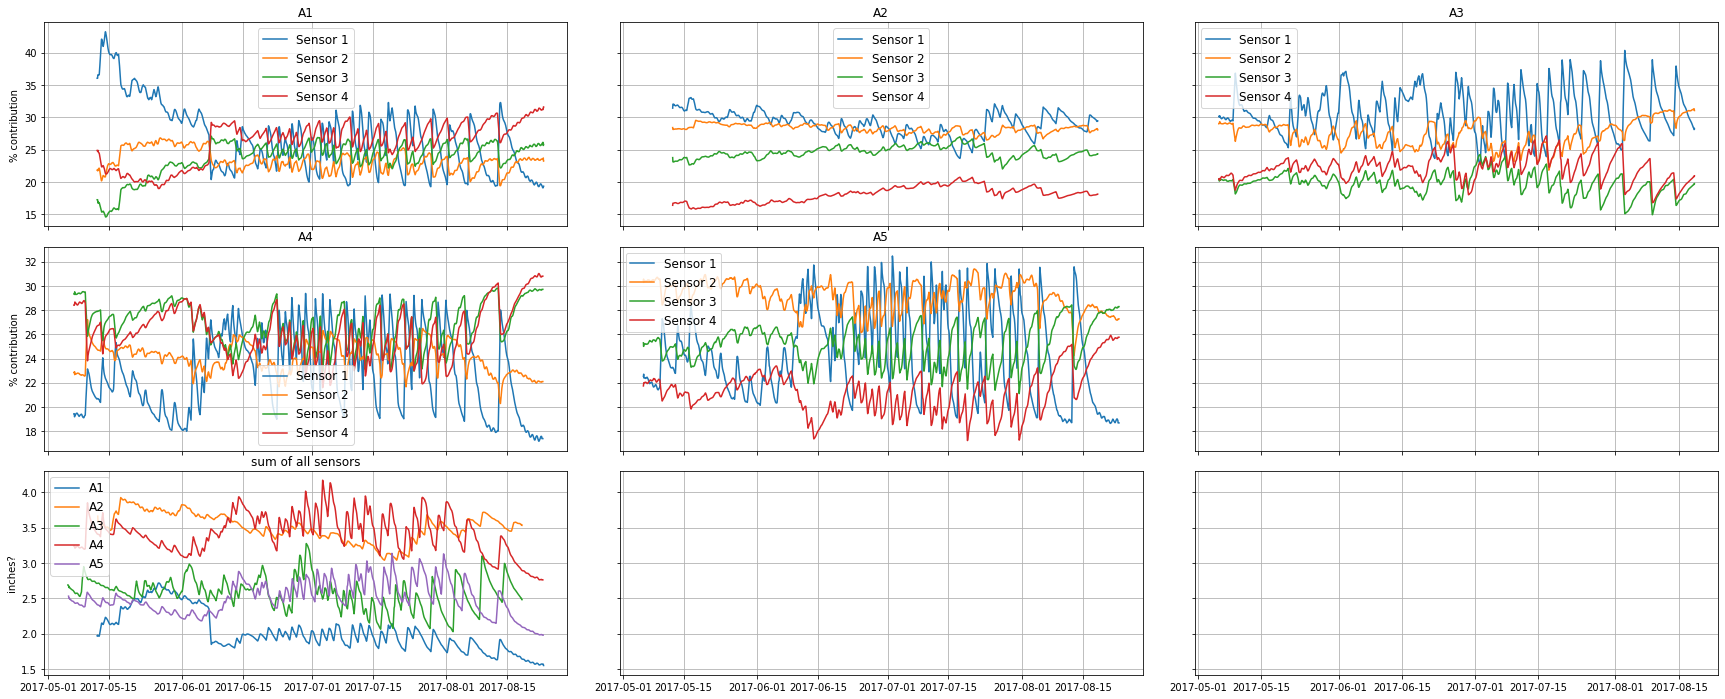

In [252]:
fig, axs = plt.subplots(3, 3, figsize=(30,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); 
ax4.grid(True); ax5.grid(True); ax6.grid(True);
ax7.grid(True); ax8.grid(True); ax9.grid(True);

ax1.plot(A1.Date.values, A1.Sensor1_contribution_smoothed.values, label="Sensor 1")
ax1.plot(A1.Date.values, A1.Sensor2_contribution_smoothed.values, label="Sensor 2")
ax1.plot(A1.Date.values, A1.Sensor3_contribution_smoothed.values, label="Sensor 3")
ax1.plot(A1.Date.values, A1.Sensor4_contribution_smoothed.values, label="Sensor 4")
ax1.legend(loc="best", fontsize=12);
ax1.set_title("A1");
ax1.set(ylabel="% contribution")
#  ax1.ylim = (0, 1.2)
# ax1.set_ylim([0.2, 1.3])

ax2.plot(A2.Date.values, A2.Sensor1_contribution_smoothed.values, label="Sensor 1")
ax2.plot(A2.Date.values, A2.Sensor2_contribution_smoothed.values, label="Sensor 2")
ax2.plot(A2.Date.values, A2.Sensor3_contribution_smoothed.values, label="Sensor 3")
ax2.plot(A2.Date.values, A2.Sensor4_contribution_smoothed.values, label="Sensor 4")
ax2.legend(loc="best", fontsize=12);
ax2.set_title("A2");
# ax2.set_ylim([0.2, 1.3])

ax3.plot(A3.Date.values, A3.Sensor1_contribution_smoothed.values, label="Sensor 1")
ax3.plot(A3.Date.values, A3.Sensor2_contribution_smoothed.values, label="Sensor 2")
ax3.plot(A3.Date.values, A3.Sensor3_contribution_smoothed.values, label="Sensor 3")
ax3.plot(A3.Date.values, A3.Sensor4_contribution_smoothed.values, label="Sensor 4")
ax3.legend(loc="best", fontsize=12);
ax3.set_title("A3");

# ax3.set_ylim([0.2, 1.3])

ax4.plot(A4.Date.values, A4.Sensor1_contribution_smoothed.values, label="Sensor 1")
ax4.plot(A4.Date.values, A4.Sensor2_contribution_smoothed.values, label="Sensor 2")
ax4.plot(A4.Date.values, A4.Sensor3_contribution_smoothed.values, label="Sensor 3")
ax4.plot(A4.Date.values, A4.Sensor4_contribution_smoothed.values, label="Sensor 4")
ax4.legend(loc="best", fontsize=12);
ax4.set(ylabel="% contribution")
ax4.set_title("A4");
# ax4.set_ylim([0.2, 1.3])

ax5.plot(A5.Date.values, A5.Sensor1_contribution_smoothed.values, label = "Sensor 1")
ax5.plot(A5.Date.values, A5.Sensor2_contribution_smoothed.values, label = "Sensor 2")
ax5.plot(A5.Date.values, A5.Sensor3_contribution_smoothed.values, label = "Sensor 3")
ax5.plot(A5.Date.values, A5.Sensor4_contribution_smoothed.values, label = "Sensor 4")
ax5.legend(loc="best", fontsize=12);
ax5.set_title("A5");
# ax5.set_ylim([0.2, 1.3])


ax7.plot(A1.Date.values, A1.sensors_sum_smoothed.values, label="A1")
ax7.plot(A2.Date.values, A2.sensors_sum_smoothed.values, label="A2")
ax7.plot(A3.Date.values, A3.sensors_sum_smoothed.values, label="A3")
ax7.plot(A4.Date.values, A4.sensors_sum_smoothed.values, label="A4")
ax7.plot(A5.Date.values, A5.sensors_sum_smoothed.values, label="A5")
ax7.legend(loc="best", fontsize=12);
ax7.set(ylabel="inches?")
ax7.set_title("sum of all sensors");
# ax6.ylim = (0, 4.2)
# ax6.set_ylim([1.3, 4.3])

file_name = plot_dir + "06_sum_and_contributions_conv_winsize_" + str(win_size) + ".png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

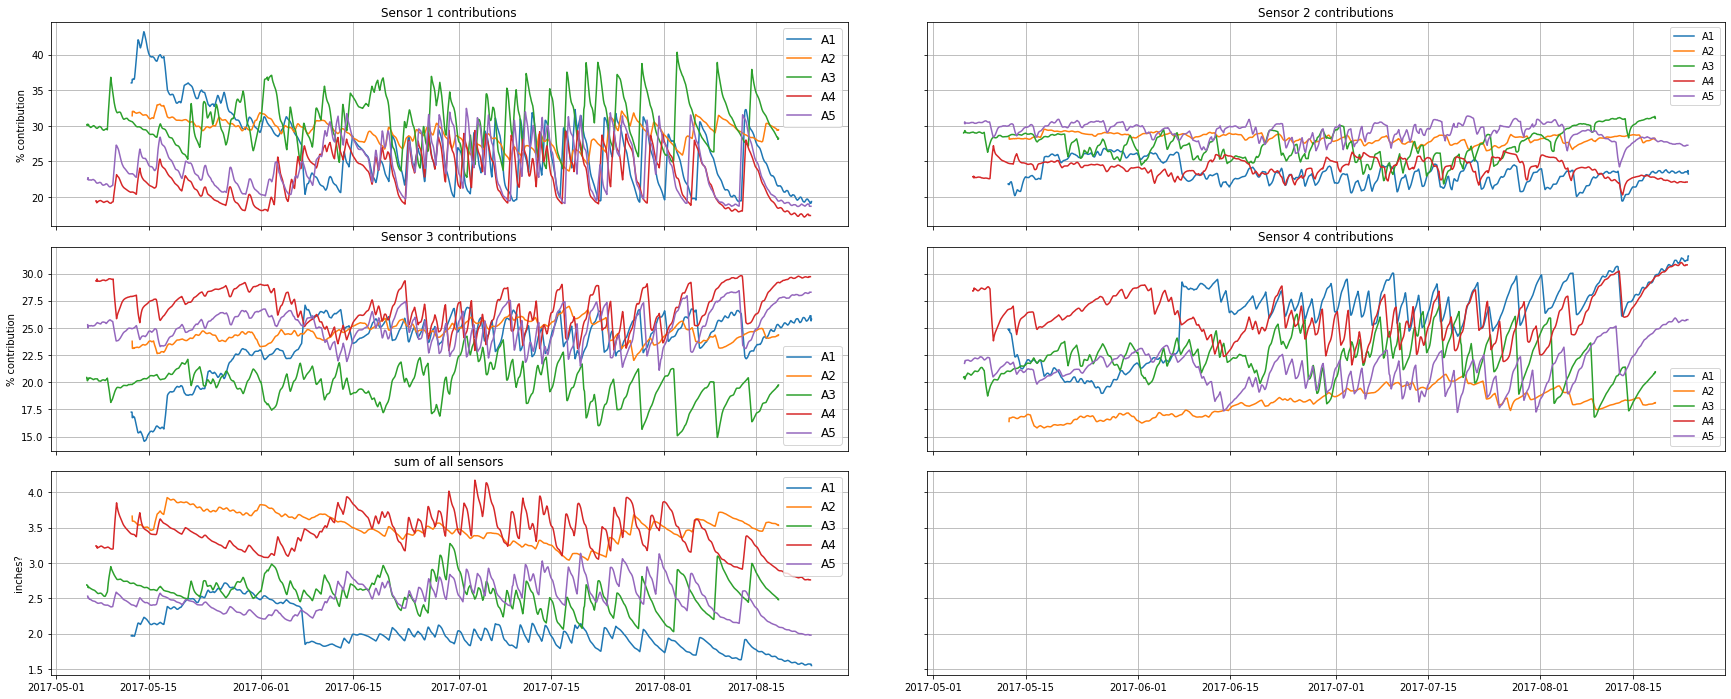

In [253]:
fig, axs = plt.subplots(3, 2, figsize=(30,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4), (ax5, ax6) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); 
ax4.grid(True); ax5.grid(True); ax6.grid(True);

ax1.plot(A1.Date.values, A1.Sensor1_contribution_smoothed.values, label="A1")
ax1.plot(A2.Date.values, A2.Sensor1_contribution_smoothed.values, label="A2")
ax1.plot(A3.Date.values, A3.Sensor1_contribution_smoothed.values, label="A3")
ax1.plot(A4.Date.values, A4.Sensor1_contribution_smoothed.values, label="A4")
ax1.plot(A5.Date.values, A5.Sensor1_contribution_smoothed.values, label="A5")
ax1.legend(loc="best", fontsize=12);
ax1.set(ylabel="% contribution")
ax1.set_title("Sensor 1 contributions");
#  ax1.ylim = (0, 1.2)
# ax1.set_ylim([0.2, 1.3])

ax2.plot(A1.Date.values, A1.Sensor2_contribution_smoothed.values, label="A1")
ax2.plot(A2.Date.values, A2.Sensor2_contribution_smoothed.values, label="A2")
ax2.plot(A3.Date.values, A3.Sensor2_contribution_smoothed.values, label="A3")
ax2.plot(A4.Date.values, A4.Sensor2_contribution_smoothed.values, label="A4")
ax2.plot(A5.Date.values, A5.Sensor2_contribution_smoothed.values, label="A5")
ax2.legend(loc="best");
ax2.set_title("Sensor 2 contributions");
# ax2.set_ylim([0.2, 1.3])

ax3.plot(A1.Date.values, A1.Sensor3_contribution_smoothed.values, label="A1")
ax3.plot(A2.Date.values, A2.Sensor3_contribution_smoothed.values, label="A2")
ax3.plot(A3.Date.values, A3.Sensor3_contribution_smoothed.values, label="A3")
ax3.plot(A4.Date.values, A4.Sensor3_contribution_smoothed.values, label="A4")
ax3.plot(A5.Date.values, A5.Sensor3_contribution_smoothed.values, label="A5")
ax3.legend(loc="best", fontsize=12);
ax3.set(ylabel="% contribution")
ax3.set_title("Sensor 3 contributions");
# ax3.set_ylim([0.2, 1.3])

ax4.plot(A1.Date.values, A1.Sensor4_contribution_smoothed.values, label="A1")
ax4.plot(A2.Date.values, A2.Sensor4_contribution_smoothed.values, label="A2")
ax4.plot(A3.Date.values, A3.Sensor4_contribution_smoothed.values, label="A3")
ax4.plot(A4.Date.values, A4.Sensor4_contribution_smoothed.values, label="A4")
ax4.plot(A5.Date.values, A5.Sensor4_contribution_smoothed.values, label="A5")
ax4.legend(loc="best");
ax4.set_title("Sensor 4 contributions");
# ax4.set_ylim([0.2, 1.3])


ax5.plot(A1.Date.values, A1.sensors_sum_smoothed.values, label="A1")
ax5.plot(A2.Date.values, A2.sensors_sum_smoothed.values, label="A2")
ax5.plot(A3.Date.values, A3.sensors_sum_smoothed.values, label="A3")
ax5.plot(A4.Date.values, A4.sensors_sum_smoothed.values, label="A4")
ax5.plot(A5.Date.values, A5.sensors_sum_smoothed.values, label="A5")
ax5.legend(loc="best", fontsize=12);
ax5.set(ylabel="inches?")
ax5.set_title("sum of all sensors");
# ax6.ylim = (0, 4.2)
# ax6.set_ylim([1.3, 4.3])

file_name = plot_dir + "07_sum_and_contributions_conv_winsize" + str(win_size) + ".png"
plt.savefig(fname = file_name, dpi=600, bbox_inches='tight')
plt.show()

In [222]:
len(np.convolve(A1['sensors_sum'], np.ones(N)/N, mode='valid'))

4919